<ipython-input-109-853be3d233ab>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df_minus['angle'] = y_df_minus.angle * -1


164.39963623874274 0.3769489594899712


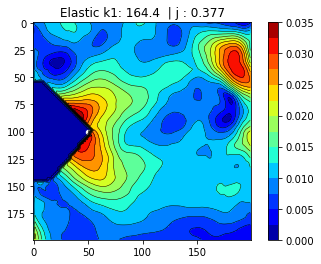

In [109]:
import DIC.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fracture
from scipy import io

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

num = 4
path = r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC'
image = dic.load_file(path)
file_num  = list(image.keys())[num][2:]

uu = io.loadmat(path+'/DIC'+'/'+file_num+'/t_uu.mat')['uu']
vv = io.loadmat(path+'/DIC'+'/'+file_num+'/t_vv.mat')['vv']
uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

exx = io.loadmat(path+'/DIC'+'/'+file_num+'/t_exx.mat')['exx']
eyy = io.loadmat(path+'/DIC'+'/'+file_num+'/t_eyy.mat')['eyy']
exy = io.loadmat(path+'/DIC'+'/'+file_num+'/t_exy.mat')['exy']
ee = fracture.effective_strain(exx, eyy, exy)
# np.savetxt(path+'/DIC'+'/'+file_num+'/ee.csv',ee)
exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
exy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )
# cv2.flip(ee_resize,1,ee_resize)
# cv2.flip(uu_resize,1,uu_resize)
# cv2.flip(vv_resize,1,vv_resize)



# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000

# Img parameter
set_angle = 60
down_level, up_level = 1,12
contour_level = 15
ratio = 2/60
left, right, up_down =50,150,100


save_path =r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC/Output'
image = dic.load_file(path)
strain_data = np.array(pd.read_csv(path+'/effective_strain_ml.csv', encoding='CP949', delimiter=' ',header=None))
strain_hardening = np.array(pd.read_csv(path+'/HRR.csv', delim_whitespace=True))
eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))


crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x

dst = ee_resize[crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]

dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
gas = dst
# gas[270:272,200:260] = 0

#
plt.imshow(dst, cmap='gray')
# plt.axis('off')
csf = plt.contourf(gas, contour_level, cmap = 'jet')
CS = plt.contour(gas, contour_level, colors='black', linewidths = 0.5)

plt.colorbar(csf)
# plt.text( 210,285, '2mm', fontsize=9, fontweight='bold')
# # plt.savefig(path+'/DIC'+'/%same_size.png'%file_num,dpi=300)
#
max_crack_tip = [left, up_down]

# max_crack_tip = [np.argmax(gas)%(left+right), np.argmax(gas)//(left+right)]#x,y
plt.scatter(max_crack_tip[0],max_crack_tip[1], color= 'white', s=20)

x = []
y = []
level_list = []

for level in range(down_level,up_level+1):
    x_num = CS.allsegs[level][0][:,0]
    y_num = CS.allsegs[level][0][:,1]
    x = np.append(x, x_num)
    y = np.append(y, y_num)

    for _ in range(len(x_num)):
        level_list = np.append(level_list,level)


vector_1 = [1,0]
vector_2 = [x-max_crack_tip[0], y-max_crack_tip[1]]
dot_product = np.dot(vector_1 / np.linalg.norm(vector_1), vector_2 / np.linalg.norm(vector_2,axis=0))
angle = np.rad2deg(np.arccos(dot_product))

df = pd.DataFrame({'level':level_list, 'x': x, 'y': y, 'angle' : angle})
x_df = df['x'] - max_crack_tip[0] > 0
df = df[x_df]
y_df_minus = df[df['y'] - max_crack_tip[1] > 0]
y_df_minus['angle'] = y_df_minus.angle * -1
y_df_plus = df[df['y'] - max_crack_tip[1] <= 0]
df = y_df_plus.append(y_df_minus)
df = df[df['angle']<=set_angle]
df = df[df['angle']>=set_angle*-1]
df['r'] = np.sqrt(np.power(df['x']- max_crack_tip[0],2)+np.power(df['y']- max_crack_tip[1],2)) * ratio *0.001

hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []



for y,x,theta in np.array(df[['y','x','angle']]):
    effective_strain = gas[np.round(y).astype(int),np.round(x).astype(int)]
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])


df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list


plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus


elastic_k1 = np.sqrt((j_integral * youngs_modulus))
plt.title('Elastic k1: ' +  str(np.round(elastic_k1,3)) + '  | j : ' + str(np.round(j_integral,3)))
# plt.scatter(df['x'],df['y'],color='black',s=0.8)
# plt.savefig(save_path+'./pdddick%d.png'%num,dpi=300, bbox_inches='tight')
print(elastic_k1,j_integral)

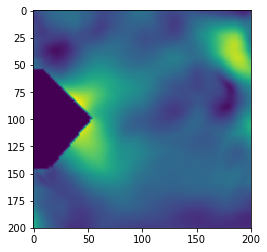

In [15]:
plt.imshow(gas)
plt.pcolormesh(gas)

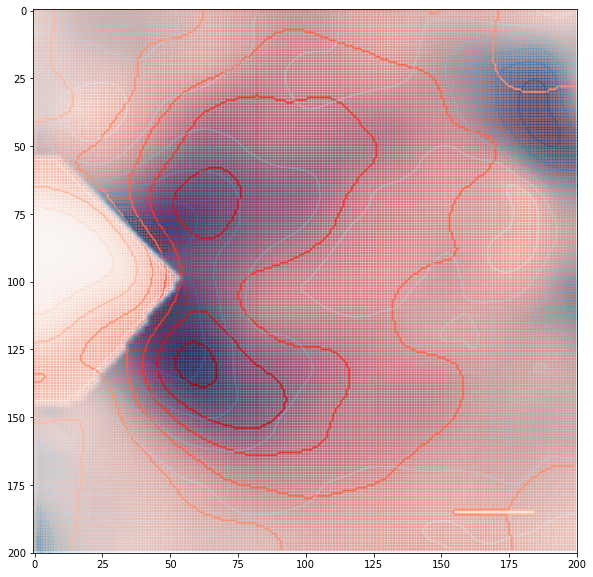

In [102]:
ml_gas = pd.read_pickle('./ml_image.pkl')
ml_gas = np.array(ml_gas)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ml_gas, alpha=1, cmap='Reds')
ax.contour(ml_gas, alpha=1, cmap='Reds')
# ax.pcolormesh(ml_gas, alpha=1)
ax.pcolormesh(gas, alpha=0.4, cmap='Blues')
ax.contour(gas, alpha=0.4, cmap='Blues')

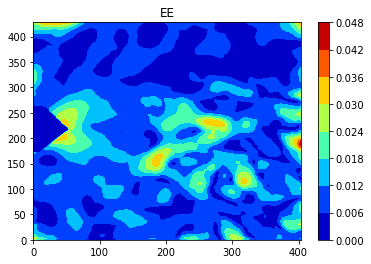

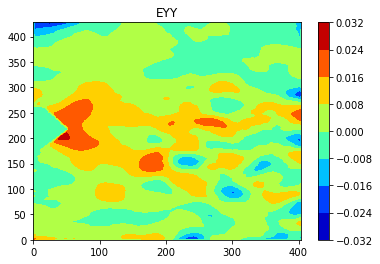

In [2]:
plt.contourf(dic.find_zone(ee_resize), cmap= 'jet')
plt.title('EE')
plt.colorbar()
plt.show()

plt.contourf(dic.find_zone(eyy_resize), cmap = 'jet')
plt.title('EYY')
plt.colorbar()
plt.show()

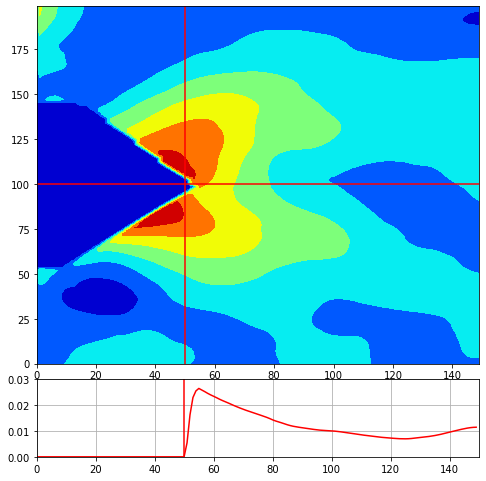

In [4]:
from matplotlib.gridspec import GridSpec

ee_resize = dst
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=6, ncols=5)
# First axes
ax0 = fig.add_subplot(gs[0:4, 0:4])
# ax0.imshow(ee_resize,cmap='gray')
plt.contourf(ee_resize, cmap= 'jet')
ax0.vlines(50,0,np.shape(ee_resize)[0]-1, color='red')
ax0.hlines(100,0,np.shape(ee_resize)[1]-1, color='red')
# ax0.axis('off')
# v axes
# ax1 = fig.add_subplot(gs[0:4, 4])
# ax1.plot(value[:,x_point],np.arange(len(value[:,x_point])),color='red')
# ax1.yaxis.set_label_position("right")
# ax1.yaxis.tick_right()
# plt.gca().invert_yaxis()
# u axes
ax2 = fig.add_subplot(gs[4, 0:4])
ax2.plot(ee_resize[100,:], color='red')
# ax2.plot(savgol_filter(value[:,y_point],31,2), color='green')
ax2.set_ylim(0,0.03)
ax2.set_xlim(0,150)
ax2.vlines(50,0,np.shape(ee_resize)[0]-1, color='red')
plt.grid()
plt.savefig(save_path+'/%sdicㅇㅇㅇ.png'%num, dpi=300)
# plt.close()
plt.show()

In [5]:
np.max(ee_resize[100,:])



0.026411672375921184